In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
BASE_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Final Project'
print(os.listdir(BASE_FILE_PATH))

['Keys', 'Setting up connection with Git-Hub.ipynb', 'entries.csv', 'summoner_details.csv', 'updated_dataset.csv', 'filtered_dataset.csv', 'filtered_dataset.gsheet', 'filtered_+30_matches_dataset.csv', 'EDA.ipynb', 'merged_dataset.csv', 'Merging match with entries and classifying accounts.ipynb', 'merged_dataset.gsheet', 'Feature engineering and cleaning vol 1.ipynb', 'Normalization_Parameters.csv', 'keepign only win feature .ipynb', 'Models without data normalization.ipynb', 'dataset_after_normalization.csv']


In [117]:
df = pd.read_csv(os.path.join(BASE_FILE_PATH, 'merged_dataset.csv'))


In [118]:
columns_to_drop = ['match_id', 'puuid', 'game_version']
df.drop(columns=columns_to_drop, inplace=True)

In [119]:
categorical_columns = ['game_mode', 'team_position', 'tier', 'rank']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   game_creation          128021 non-null  int64  
 1   game_duration          128021 non-null  int64  
 2   map_id                 128021 non-null  int64  
 3   summoner_id            128021 non-null  object 
 4   champion_id            128021 non-null  int64  
 5   kills                  128021 non-null  int64  
 6   deaths                 128021 non-null  int64  
 7   assists                128021 non-null  int64  
 8   total_damage_dealt     128021 non-null  int64  
 9   total_damage_taken     128021 non-null  int64  
 10  gold_earned            128021 non-null  int64  
 11  vision_score           128021 non-null  int64  
 12  total_minions_killed   128021 non-null  int64  
 13  win                    128021 non-null  bool   
 14  game_duration_min      128021 non-nu

In [121]:
#winsorizing features by game_mode = CHERRY to then normalize all features by game_mode

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

# Winsorize features only for CHERRY Game Mode
df_cherry = df[df['game_mode_CHERRY'] == True].copy()
features_to_winsorize = [
    'kills', 'deaths', 'assists', 'gold_earned', 'game_duration',
    'total_damage_dealt', 'total_damage_taken', 'total_minions_killed'
]

for feature in features_to_winsorize:
    df_cherry[f'{feature}_winsorized'] = winsorize(df_cherry[feature], limits=[0.01, 0.01])

# Update the main DataFrame only for CHERRY game mode rows
for feature in features_to_winsorize:
    df.loc[df['game_mode_CHERRY'], feature] = df_cherry[f'{feature}_winsorized']

# Normalize the features for each game mode separately
game_modes = ['game_mode_ARAM', 'game_mode_CHERRY', 'game_mode_CLASSIC']
for mode in game_modes:
    df_mode = df[df[mode] == True]
    scaler = StandardScaler()
    for feature in features_to_winsorize:
        if df_mode.shape[0] > 0:  # Check if there are entries for the mode
            df.loc[df[mode], f'{feature}_normalized'] = scaler.fit_transform(df_mode[[feature]])

# Check the dataframe info and head to confirm the changes
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 44 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   game_creation                    128021 non-null  int64  
 1   game_duration                    128021 non-null  int64  
 2   map_id                           128021 non-null  int64  
 3   summoner_id                      128021 non-null  object 
 4   champion_id                      128021 non-null  int64  
 5   kills                            128021 non-null  int64  
 6   deaths                           128021 non-null  int64  
 7   assists                          128021 non-null  int64  
 8   total_damage_dealt               128021 non-null  int64  
 9   total_damage_taken               128021 non-null  int64  
 10  gold_earned                      128021 non-null  int64  
 11  vision_score                     128021 non-null  int64  
 12  to

,game_creation,game_duration,map_id,summoner_id,champion_id,kills,deaths,assists,total_damage_dealt,total_damage_taken,...,rank_III,rank_IV,kills_normalized,deaths_normalized,assists_normalized,gold_earned_normalized,game_duration_normalized,total_damage_dealt_normalized,total_damage_taken_normalized,total_minions_killed_normalized
0,1712434308642,1087,11,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,17,3,1,5,21894,6011,...,False,True,-0.678147,-1.383072,-0.420678,-1.258582,-1.226514,-1.324098,-1.407530,-1.025501
1,1721508545865,1282,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,30,14,19,26,138247,41918,...,False,True,0.391910,2.069280,0.183700,0.767557,0.509081,1.526262,0.600897,2.300653
2,1721513174857,1327,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,161,12,13,29,110883,33804,...,False,True,0.102877,0.597786,0.474439,0.249953,0.665935,0.901536,0.121671,0.760642
3,1721575116568,1344,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,15,6,20,31,135813,42284,...,False,True,-0.764221,2.314529,0.668265,0.293223,0.725191,1.470693,0.622514,2.169588
4,1721577348686,1261,12,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,238,11,16,18,62148,30458,...,False,True,-0.041639,1.333533,-0.591604,0.392009,0.435882,-0.211094,-0.075949,-0.713836


In [122]:
print(df[['kills_normalized', 'deaths_normalized', 'assists_normalized',
          'gold_earned_normalized', 'game_duration_normalized',
          'total_damage_dealt_normalized', 'total_damage_taken_normalized',
          'total_minions_killed_normalized']].describe())

       kills_normalized  deaths_normalized  assists_normalized  \
count      1.280210e+05       1.280210e+05        1.280210e+05   
mean      -7.370672e-17      -5.350397e-17       -6.438237e-18   
std        1.000004e+00       1.000004e+00        1.000004e+00   
min       -1.631318e+00      -2.590450e+00       -2.336038e+00   
25%       -6.781466e-01      -8.020271e-01       -7.728958e-01   
50%       -1.861553e-01       6.954001e-02       -2.445684e-01   
75%        5.364263e-01       6.505848e-01        4.744390e-01   
max        9.388125e+00       9.366256e+00        8.913106e+00   

       gold_earned_normalized  game_duration_normalized  \
count            1.280210e+05              1.280210e+05   
mean             1.468584e-16             -2.285574e-16   
std              1.000004e+00              1.000004e+00   
min             -3.330817e+00             -3.603981e+00   
25%             -6.436703e-01             -5.180360e-01   
50%             -2.988733e-02              5.943234

In [123]:
#Exporting the Normalization Params based on game_mode to use it in predictions on new players matches

features = ['kills', 'deaths', 'assists', 'gold_earned', 'game_duration',
            'total_damage_dealt', 'total_damage_taken', 'total_minions_killed']

# Create a DataFrame to hold the normalization parameters
norm_params = pd.DataFrame(columns=['Feature', 'Mean', 'StdDev'])

# Calculate mean and standard deviation for each feature
for feature in features:
    mean_val = df[feature + '_normalized'].mean()
    std_val = df[feature + '_normalized'].std()
    # Create a DataFrame for the current row and concatenate it with the main DataFrame
    new_row = pd.DataFrame({'Feature': [feature], 'Mean': [mean_val], 'StdDev': [std_val]})
    norm_params = pd.concat([norm_params, new_row], ignore_index=True)

# Export to CSV
norm_params.to_csv(os.path.join(BASE_FILE_PATH, 'Normalization_Parameters_by_Game_Mode.csv'), index=False)

<ipython-input-123-a7da032aa3bf>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  norm_params = pd.concat([norm_params, new_row], ignore_index=True)


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 44 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   game_creation                    128021 non-null  int64  
 1   game_duration                    128021 non-null  int64  
 2   map_id                           128021 non-null  int64  
 3   summoner_id                      128021 non-null  object 
 4   champion_id                      128021 non-null  int64  
 5   kills                            128021 non-null  int64  
 6   deaths                           128021 non-null  int64  
 7   assists                          128021 non-null  int64  
 8   total_damage_dealt               128021 non-null  int64  
 9   total_damage_taken               128021 non-null  int64  
 10  gold_earned                      128021 non-null  int64  
 11  vision_score                     128021 non-null  int64  
 12  to

In [125]:
##Normalizing features based on the team_position
# Define the features to normalize
features_to_normalize = [
    'kills', 'deaths', 'assists', 'gold_earned',
    'total_damage_dealt', 'total_damage_taken', 'total_minions_killed'
]

# List of team positions based on your one-hot encoded columns
team_positions = ['All Mid', 'BOTTOM', 'Duo', 'JUNGLE', 'MIDDLE', 'TOP', 'UTILITY', 'Unknown']

# Normalize each feature within each team position
for position in team_positions:
    column_name = f'team_position_{position}'
    for feature in features_to_normalize:
        # Use the one-hot encoded column to filter the DataFrame
        subset = df[df[column_name] == 1]

        # Calculate mean and standard deviation for the feature within the subset
        mean_val = subset[feature].mean()
        std_val = subset[feature].std()

        # Normalize the feature within the team position and store in a new column
        df.loc[df[column_name] == 1, f'{feature}_normalized_{position}'] = (df[feature] - mean_val) / std_val

In [126]:
df.columns.tolist()

['game_creation',
 'game_duration',
 'map_id',
 'summoner_id',
 'champion_id',
 'kills',
 'deaths',
 'assists',
 'total_damage_dealt',
 'total_damage_taken',
 'gold_earned',
 'vision_score',
 'total_minions_killed',
 'win',
 'game_duration_min',
 'game_creation_dt',
 'time_segment',
 'days_since_last_game',
 'time_group',
 'binary_time_group',
 'game_mode_ARAM',
 'game_mode_CHERRY',
 'game_mode_CLASSIC',
 'team_position_All Mid',
 'team_position_BOTTOM',
 'team_position_Duo',
 'team_position_JUNGLE',
 'team_position_MIDDLE',
 'team_position_TOP',
 'team_position_UTILITY',
 'team_position_Unknown',
 'tier_GOLD',
 'rank_I',
 'rank_II',
 'rank_III',
 'rank_IV',
 'kills_normalized',
 'deaths_normalized',
 'assists_normalized',
 'gold_earned_normalized',
 'game_duration_normalized',
 'total_damage_dealt_normalized',
 'total_damage_taken_normalized',
 'total_minions_killed_normalized',
 'kills_normalized_All Mid',
 'deaths_normalized_All Mid',
 'assists_normalized_All Mid',
 'gold_earned_nor

In [127]:
df['game_creation_dt'] = pd.to_datetime(df['game_creation_dt'])

# Define bins based on quantiles
quantiles = df['game_creation_dt'].quantile([0, 0.33, 0.67, 1]).to_list()
df['time_segment'] = pd.cut(df['game_creation_dt'], bins=quantiles, labels=['initial', 'mid', 'late'], include_lowest=True)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 100 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   game_creation                            128021 non-null  int64         
 1   game_duration                            128021 non-null  int64         
 2   map_id                                   128021 non-null  int64         
 3   summoner_id                              128021 non-null  object        
 4   champion_id                              128021 non-null  int64         
 5   kills                                    128021 non-null  int64         
 6   deaths                                   128021 non-null  int64         
 7   assists                                  128021 non-null  int64         
 8   total_damage_dealt                       128021 non-null  int64         
 9   total_damage_taken       

In [129]:
df.drop(columns=['game_creation_dt', 'time_group'], inplace=True)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 98 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   game_creation                            128021 non-null  int64   
 1   game_duration                            128021 non-null  int64   
 2   map_id                                   128021 non-null  int64   
 3   summoner_id                              128021 non-null  object  
 4   champion_id                              128021 non-null  int64   
 5   kills                                    128021 non-null  int64   
 6   deaths                                   128021 non-null  int64   
 7   assists                                  128021 non-null  int64   
 8   total_damage_dealt                       128021 non-null  int64   
 9   total_damage_taken                       128021 non-null  int64   
 10  gold_earned         

In [131]:
# Removing original and unrelated feature columns
columns_to_drop = ['game_creation', 'game_duration', 'map_id', 'champion_id',
                   'kills', 'deaths', 'assists', 'total_damage_dealt',
                   'total_damage_taken', 'gold_earned', 'vision_score',
                   'total_minions_killed', 'game_duration_min'] + \
                  [f'{feat}_original' for feat in features_to_winsorize]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [132]:
df.columns.tolist()

['summoner_id',
 'win',
 'time_segment',
 'days_since_last_game',
 'binary_time_group',
 'game_mode_ARAM',
 'game_mode_CHERRY',
 'game_mode_CLASSIC',
 'team_position_All Mid',
 'team_position_BOTTOM',
 'team_position_Duo',
 'team_position_JUNGLE',
 'team_position_MIDDLE',
 'team_position_TOP',
 'team_position_UTILITY',
 'team_position_Unknown',
 'tier_GOLD',
 'rank_I',
 'rank_II',
 'rank_III',
 'rank_IV',
 'kills_normalized',
 'deaths_normalized',
 'assists_normalized',
 'gold_earned_normalized',
 'game_duration_normalized',
 'total_damage_dealt_normalized',
 'total_damage_taken_normalized',
 'total_minions_killed_normalized',
 'kills_normalized_All Mid',
 'deaths_normalized_All Mid',
 'assists_normalized_All Mid',
 'gold_earned_normalized_All Mid',
 'total_damage_dealt_normalized_All Mid',
 'total_damage_taken_normalized_All Mid',
 'total_minions_killed_normalized_All Mid',
 'kills_normalized_BOTTOM',
 'deaths_normalized_BOTTOM',
 'assists_normalized_BOTTOM',
 'gold_earned_normalized_

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 85 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   summoner_id                              128021 non-null  object  
 1   win                                      128021 non-null  bool    
 2   time_segment                             128021 non-null  category
 3   days_since_last_game                     128021 non-null  int64   
 4   binary_time_group                        128021 non-null  object  
 5   game_mode_ARAM                           128021 non-null  bool    
 6   game_mode_CHERRY                         128021 non-null  bool    
 7   game_mode_CLASSIC                        128021 non-null  bool    
 8   team_position_All Mid                    128021 non-null  bool    
 9   team_position_BOTTOM                     128021 non-null  bool    
 10  team_position_Duo   

In [134]:
df = df.drop([
    'game_mode_ARAM', 'game_mode_CHERRY', 'game_mode_CLASSIC',
    'team_position_All Mid', 'team_position_BOTTOM', 'team_position_Duo',
    'team_position_JUNGLE', 'team_position_MIDDLE', 'team_position_TOP',
    'team_position_UTILITY', 'team_position_Unknown', 'tier_GOLD',
    'rank_I', 'rank_II', 'rank_III', 'rank_IV', 'days_since_last_game'
], axis=1)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 68 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   summoner_id                              128021 non-null  object  
 1   win                                      128021 non-null  bool    
 2   time_segment                             128021 non-null  category
 3   binary_time_group                        128021 non-null  object  
 4   kills_normalized                         128021 non-null  float64 
 5   deaths_normalized                        128021 non-null  float64 
 6   assists_normalized                       128021 non-null  float64 
 7   gold_earned_normalized                   128021 non-null  float64 
 8   game_duration_normalized                 128021 non-null  float64 
 9   total_damage_dealt_normalized            128021 non-null  float64 
 10  total_damage_taken_n

In [136]:
# Fill numeric columns with 0
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# For categorical columns, you might want to add a category, or convert to string
categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    df[col] = df[col].cat.add_categories([0]).fillna(0)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 68 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   summoner_id                              128021 non-null  object  
 1   win                                      128021 non-null  bool    
 2   time_segment                             128021 non-null  category
 3   binary_time_group                        128021 non-null  object  
 4   kills_normalized                         128021 non-null  float64 
 5   deaths_normalized                        128021 non-null  float64 
 6   assists_normalized                       128021 non-null  float64 
 7   gold_earned_normalized                   128021 non-null  float64 
 8   game_duration_normalized                 128021 non-null  float64 
 9   total_damage_dealt_normalized            128021 non-null  float64 
 10  total_damage_taken_n

In [138]:
df.drop(columns=['win'], inplace=True)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128021 entries, 0 to 128020
Data columns (total 67 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   summoner_id                              128021 non-null  object  
 1   time_segment                             128021 non-null  category
 2   binary_time_group                        128021 non-null  object  
 3   kills_normalized                         128021 non-null  float64 
 4   deaths_normalized                        128021 non-null  float64 
 5   assists_normalized                       128021 non-null  float64 
 6   gold_earned_normalized                   128021 non-null  float64 
 7   game_duration_normalized                 128021 non-null  float64 
 8   total_damage_dealt_normalized            128021 non-null  float64 
 9   total_damage_taken_normalized            128021 non-null  float64 
 10  total_minions_killed

In [140]:
df.head()

,summoner_id,time_segment,binary_time_group,kills_normalized,deaths_normalized,assists_normalized,gold_earned_normalized,game_duration_normalized,total_damage_dealt_normalized,total_damage_taken_normalized,...,total_damage_dealt_normalized_UTILITY,total_damage_taken_normalized_UTILITY,total_minions_killed_normalized_UTILITY,kills_normalized_Unknown,deaths_normalized_Unknown,assists_normalized_Unknown,gold_earned_normalized_Unknown,total_damage_dealt_normalized_Unknown,total_damage_taken_normalized_Unknown,total_minions_killed_normalized_Unknown
0,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,initial,Active,-0.678147,-1.383072,-0.420678,-1.258582,-1.226514,-1.324098,-1.407530,...,-0.610752,-1.275624,0.029368,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,mid,Active,0.391910,2.069280,0.183700,0.767557,0.509081,1.526262,0.600897,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,mid,Active,0.102877,0.597786,0.474439,0.249953,0.665935,0.901536,0.121671,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,mid,Active,-0.764221,2.314529,0.668265,0.293223,0.725191,1.470693,0.622514,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE,mid,Active,-0.041639,1.333533,-0.591604,0.392009,0.435882,-0.211094,-0.075949,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
# Exclude non-numeric columns from the DataFrame before grouping
numeric_cols = df.select_dtypes(include=[np.number])  # This selects only numeric columns
df_numeric = df[['summoner_id', 'time_segment'] + list(numeric_cols.columns)]

# Addressing the FutureWarning by setting observed=True if the DataFrame contains any categorical data
grouped_df = df_numeric.groupby(['summoner_id', 'time_segment'], observed=True).mean()

# Pivoting the data so each 'time_segment' becomes a column
pivot_df = grouped_df.unstack(level='time_segment')

# Flattening the columns to make them more manageable
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Resetting the index so 'summoner_id' becomes a column
pivot_df.reset_index(inplace=True)

# Optionally, fill any NaN values that may arise from empty segments
pivot_df.fillna(0, inplace=True)

# Display the first few rows to verify
print(pivot_df.head())

                                         summoner_id  \
0   --yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE   
1   -0FAl-E5gzHW35MsMHI7ZBv4jCme6S8TT2W7az4-G7x7Y-Yy   
2    -1ddPTjEGbdaQR2HcKWdP0qkBfSjsyJcFot0WGcyGxkjSy4   
3  -2ksdxdFEy1AnyqNsmO-RI_2n8ic7mAzN5-LYGvttHTwY2...   
4    -3ntNAfsqQ8f8pHSCh805dnhlQvmv2_GYLWxhwDfn6I1h2g   

   kills_normalized_initial  kills_normalized_mid  kills_normalized_late  \
0                 -0.678147             -0.245808              -0.521261   
1                 -0.203322             -0.583182              -0.062466   
2                  0.662533              0.320202               0.208192   
3                  0.366466              0.102462              -0.025106   
4                  0.370595              1.017654               0.000000   

   deaths_normalized_initial  deaths_normalized_mid  deaths_normalized_late  \
0                  -1.383072               0.594446                0.063105   
1                  -0.511505              -0.511

In [142]:
# Extract binary_time_group and summoner_id, and drop duplicates
binary_time_mapping = df[['summoner_id', 'binary_time_group']].drop_duplicates()

# Merge this mapping into the pivot_df
pivot_df = pivot_df.merge(binary_time_mapping, on='summoner_id', how='left')

# Display the first few rows to verify the merge
print(pivot_df.head())

                                         summoner_id  \
0   --yDuIIktIqjdme32tV29wcBIFPE08CY8WhiZhL4Gd6p60aE   
1   -0FAl-E5gzHW35MsMHI7ZBv4jCme6S8TT2W7az4-G7x7Y-Yy   
2    -1ddPTjEGbdaQR2HcKWdP0qkBfSjsyJcFot0WGcyGxkjSy4   
3  -2ksdxdFEy1AnyqNsmO-RI_2n8ic7mAzN5-LYGvttHTwY2...   
4    -3ntNAfsqQ8f8pHSCh805dnhlQvmv2_GYLWxhwDfn6I1h2g   

   kills_normalized_initial  kills_normalized_mid  kills_normalized_late  \
0                 -0.678147             -0.245808              -0.521261   
1                 -0.203322             -0.583182              -0.062466   
2                  0.662533              0.320202               0.208192   
3                  0.366466              0.102462              -0.025106   
4                  0.370595              1.017654               0.000000   

   deaths_normalized_initial  deaths_normalized_mid  deaths_normalized_late  \
0                  -1.383072               0.594446                0.063105   
1                  -0.511505              -0.511

In [143]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Columns: 194 entries, summoner_id to binary_time_group
dtypes: float64(192), object(2)
memory usage: 3.4+ MB


In [144]:
pivot_df.drop(columns=['summoner_id'], inplace=True)

In [145]:
from sklearn.metrics import classification_report, accuracy_score
# 1. Split the data into features and target
X = pivot_df.drop('binary_time_group', axis=1)
y = pivot_df['binary_time_group']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.5340659340659341
Classification Report:
              precision    recall  f1-score   support

      Active       0.54      0.62      0.58       233
    Inactive       0.53      0.45      0.48       222

    accuracy                           0.53       455
   macro avg       0.53      0.53      0.53       455
weighted avg       0.53      0.53      0.53       455



In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier

# Prepare data
X = pivot_df.drop(['binary_time_group'], axis=1)
y = pivot_df['binary_time_group']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)

# Gradient Boosting Machine
gbm = LGBMClassifier(random_state=42)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Gradient Boosting Machine Performance:")
print(classification_report(y_test, y_pred_gbm))

[LightGBM] [Info] Number of positive: 891, number of negative: 928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38344
[LightGBM] [Info] Number of data points in the train set: 1819, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489830 -> initscore=-0.040687
[LightGBM] [Info] Start training from score -0.040687
Logistic Regression Performance:
              precision    recall  f1-score   support

      Active       0.61      0.56      0.58       238
    Inactive       0.56      0.60      0.58       217

    accuracy                           0.58       455
   macro avg       0.58      0.58      0.58       455
weighted avg       0.58      0.58      0.58       455

Random Forest Performance:
              precision    recall  f1-score   support

   

<Figure size 1200x600 with 0 Axes>

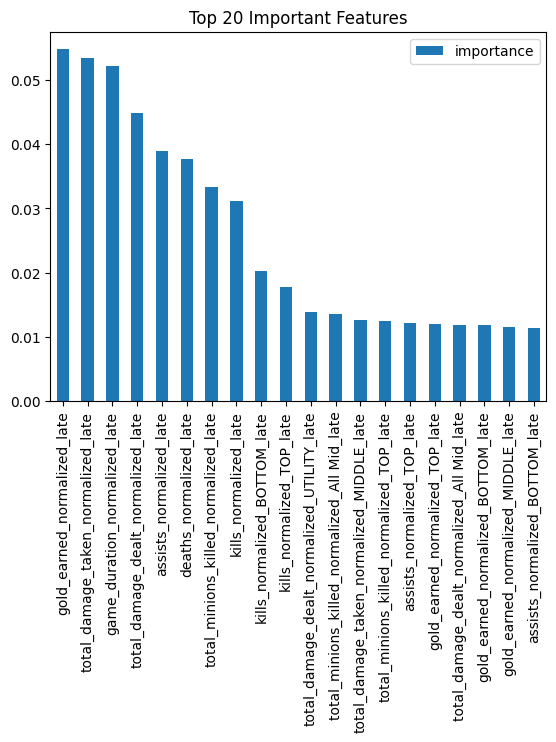

In [147]:
#indentifying important features for RF
feature_importances = pd.DataFrame(random_forest.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
feature_importances[:20].plot(kind='bar')
plt.title('Top 20 Important Features')
plt.show()

<Figure size 1200x600 with 0 Axes>

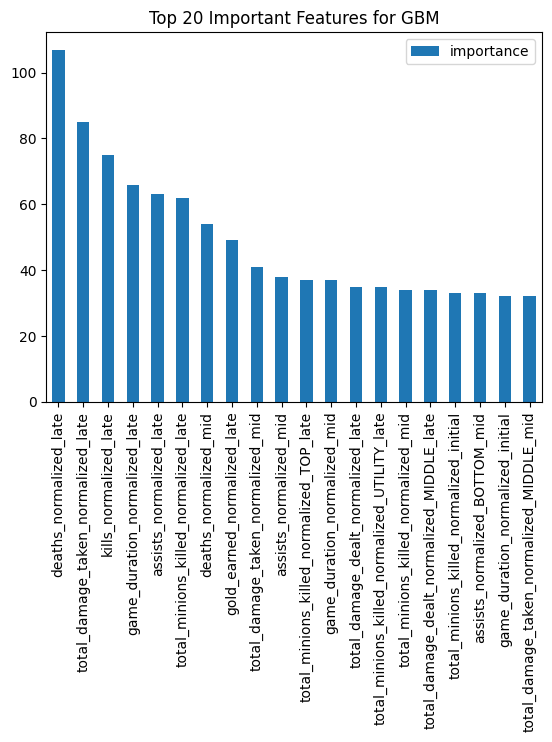

In [148]:
#identifying important features for GBM
feature_importances_gbm = pd.DataFrame(gbm.feature_importances_,
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
feature_importances_gbm[:20].plot(kind='bar')
plt.title('Top 20 Important Features for GBM')
plt.show()

In [149]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,577 (64.75 KB)

 Trainable params: 16,577 (64.75 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Convert categorical binary_time_group to numeric
y_train = y_train.map({'Active': 1, 'Inactive': 0}).astype('float')

In [151]:
# Check if conversion was successful
print(y_train.dtype)

# Re-run the model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

float64
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5181 - loss: 0.6917 - val_accuracy: 0.5192 - val_loss: 0.6937
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6035 - loss: 0.6600 - val_accuracy: 0.5302 - val_loss: 0.6873
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6882 - loss: 0.6313 - val_accuracy: 0.6071 - val_loss: 0.6829
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7461 - loss: 0.5999 - val_accuracy: 0.6126 - val_loss: 0.6822
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7812 - loss: 0.5498 - val_accuracy: 0.6346 - val_loss: 0.6835
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8092 - loss: 0.4964 - val_accuracy: 0.6538 - val_loss: 0.6846
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8408 - loss: 0.4457 - val_accuracy: 0.6566 - val_loss: 0.7102
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8536 - loss: 0.4063 - val_accuracy: 0.6566 - v

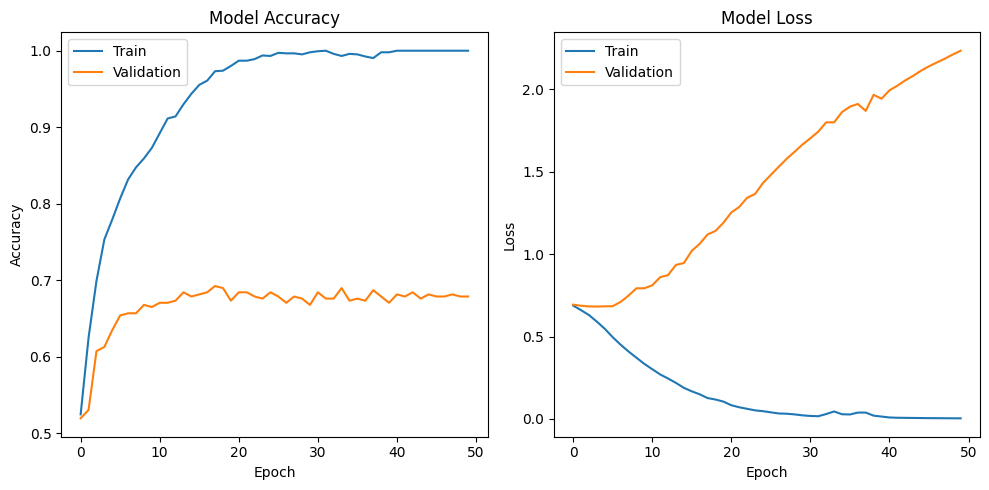

In [152]:
# Summarize history for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [153]:
y_test = y_test.replace({'Active': 1, 'Inactive': 0})

In [154]:
# Assuming you have a test set X_test and y_test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

15/15 - 0s - 10ms/step - accuracy: 0.6813 - loss: 2.0500
Test Accuracy: 0.6813
Test Loss: 2.0500


In [155]:
#selecting top20 most important features to verify if models predictions improve
top_features = [
    'deaths_normalized_late', 'kills_normalized_late', 'assists_normalized_late',
    'game_duration_normalized_late', 'total_minions_killed_normalized_late',
    'gold_earned_normalized_late', 'total_damage_dealt_normalized_late',
    'total_damage_taken_normalized_late', 'deaths_normalized_mid',
    'kills_normalized_mid', 'assists_normalized_mid', 'game_duration_normalized_mid',
    'total_minions_killed_normalized_mid', 'gold_earned_normalized_mid',
    'total_damage_dealt_normalized_mid', 'total_damage_taken_normalized_mid',
    'deaths_normalized_initial', 'kills_normalized_initial', 'assists_normalized_initial',
    'game_duration_normalized_initial'
]


# Creating a new DataFrame that includes only the top features and the target variable
top_features_df = pivot_df[top_features + ['binary_time_group']]


In [156]:
#reduce the number of datapoints in the dataset to avoid overfitting
# Filter and sample active players
active_samples = top_features_df[top_features_df['binary_time_group'] == 'Active'].sample(n=200, random_state=42)

# Filter and sample inactive players
inactive_samples = top_features_df[top_features_df['binary_time_group'] == 'Inactive'].sample(n=200, random_state=42)

# Combine both samples into a new DataFrame
filtered_df = pd.concat([active_samples, inactive_samples])

# Shuffle the DataFrame to mix active and inactive entries
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [157]:
# Prepare data
X = filtered_df.drop(['binary_time_group'], axis=1)
y = filtered_df['binary_time_group']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [158]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)

# Gradient Boosting Machine
gbm = LGBMClassifier(random_state=42)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Gradient Boosting Machine Performance:")
print(classification_report(y_test, y_pred_gbm))

[LightGBM] [Info] Number of positive: 162, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1549
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506250 -> initscore=0.025001
[LightGBM] [Info] Start training from score 0.025001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [159]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
# Convert categorical binary_time_group to numeric
y_train = y_train.map({'Active': 1, 'Inactive': 0}).astype('float')

In [161]:
# Check if conversion was successful
print(y_train.dtype)

# Re-run the model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

float64
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4533 - loss: 0.6968 - val_accuracy: 0.6250 - val_loss: 0.6696
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5951 - loss: 0.6854 - val_accuracy: 0.6875 - val_loss: 0.6635
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6421 - loss: 0.6757 - val_accuracy: 0.6562 - val_loss: 0.6612
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6740 - loss: 0.6664 - val_accuracy: 0.6406 - val_loss: 0.6561
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6648 - loss: 0.6544 - val_accuracy: 0.6719 - val_loss: 0.6498
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7371 - loss: 0.6512 - val_accuracy: 0.7031 - val_loss: 0.6459
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6917 - loss: 0.6453 - val_accuracy: 0.7344 - val_loss: 0.6428
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7262 - loss: 0.6297 - val_accuracy: 0.7031 - val_loss: 0.6386

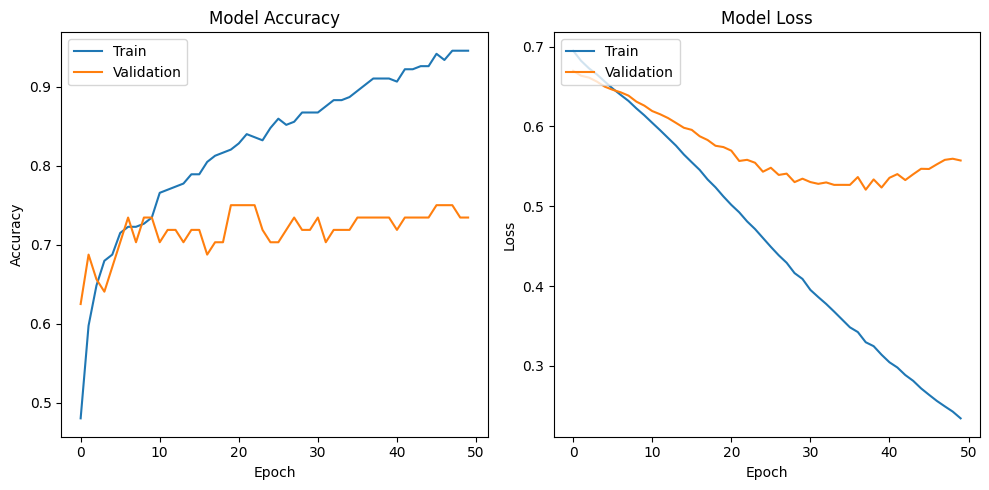

In [162]:
# Summarize history for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [163]:
y_test = y_test.replace({'Active': 1, 'Inactive': 0})

In [164]:
# Assuming you have a test set X_test and y_test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 - 0s - 67ms/step - accuracy: 0.6000 - loss: 0.8594
Test Accuracy: 0.6000
Test Loss: 0.8594
